# 📌 Intro.

- Transfomer 를 학습하는 노드에서 영어로 챗봇을 만드는 실습을 하였습니다.
- 이번에는 한국어 데이터셋을 활용하여 챗봇을 만드는 프로젝트를 진행합니다.
- 데이터는 송영숙님이 공개한 챗봇데이터를 사용합니다.

[songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)

- 학습때와 달리 한국어 데이터를 처리하는 것으로 별도의 전처리 과정이 필요합니다.
- 이번 프로젝트는 총 5개의 STEP으로 진행되어야 합니다.
  - STEP 1. 데이터 수집하기
  - STEP 2. 데이터 전처리하기
  - STEP 3. SubwordTextEncoder 사용하기
  - STEP 4. 모델 구성하기
  - STEP 5. 모델 평가하기

---

- 이번 프로젝트의 평가 루브릭은 아래와 같습니다.

| 평가문항                                                                     | 평가결과                                                                                                                 |
| ---------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------ |
| 1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.                          | - 데이터의 공백과 특수문자 처리가 적절히 이루어졌습니다.<br>- 토크나이징 작업이 수행되어 병렬 데이터셋이 구축되었습니다. |
| 2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다. | - 구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였습니다.                                         |
| 3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.               | - 한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였습니다.                                                          |


# STEP 1. 데이터 수집하기


- Kopora 라이브러리를 사용해 데이터 로더로 불러오려 하였으나 url에러로 데이터 로더가 작동하지 않아 GitHub에서 직접 데이터를 다운로드 합니다.


```python
# 기존 데이터 로더 코드
from Korpora import KoreanChatbotKorpus

corpus = KoreanChatbotKorpus()
```

- 정상 로드시 아래의 문구가 출력됩니다.


[korean_chatbot_data] download ChatbotData.csv: 893kB [00:00, 14.3MB/s]

    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : songys@github
    Repository : https://github.com/songys/Chatbot_data
    References :

    Chatbot_data_for_Korean v1.0
      1. 챗봇 트레이닝용 문답 페어 11,876개
      2. 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링
    자세한 내용은 위의 repository를 참고하세요.

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/


- URL오류로 직접 데이터 제공자의 Github에 공개된 데이터를 직접 다운로드 합니다.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


## 데이터 EDA


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

In [ ]:
# 기본 정보 출력
print("Chatbot 샘플 개수:")
print(len(train_data))
print("\n결측치 수:")
print(train_data.isnull().sum())

Chatbot 샘플 개수:
11823

결측치 수:
Q        0
A        0
label    0
dtype: int64


In [ ]:
# 레이블 분포 확인
print("\n레이블 분포:\n", train_data['label'].value_counts())


레이블 분포:
 0    5290
1    3570
2    2963
Name: label, dtype: int64


In [ ]:
# 문장 길이 분석
train_data['Q_length'] = train_data['Q'].apply(lambda x: len(x.split()))
train_data['A_length'] = train_data['A'].apply(lambda x: len(x.split()))
print("\n질문 길이 통계:\n", train_data['Q_length'].describe())
print("\n답변 길이 통계:\n", train_data['A_length'].describe())


질문 길이 통계:
 count    11823.000000
mean         3.587414
std          1.618897
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         15.000000
Name: Q_length, dtype: float64

답변 길이 통계:
 count    11823.000000
mean         3.693648
std          1.857292
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         21.000000
Name: A_length, dtype: float64


In [ ]:
# 단어 빈도 분석
all_words = ' '.join(train_data['Q']).split() + ' '.join(train_data['A']).split()
word_counts = Counter(all_words)
print("\n가장 흔한 단어 10개:\n", word_counts.most_common(10))


가장 흔한 단어 10개:
 [('거예요.', 1031), ('수', 647), ('너무', 638), ('더', 556), ('좋아하는', 538), ('거', 476), ('잘', 470), ('것', 428), ('많이', 405), ('안', 389)]


선택된 폰트: /usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf


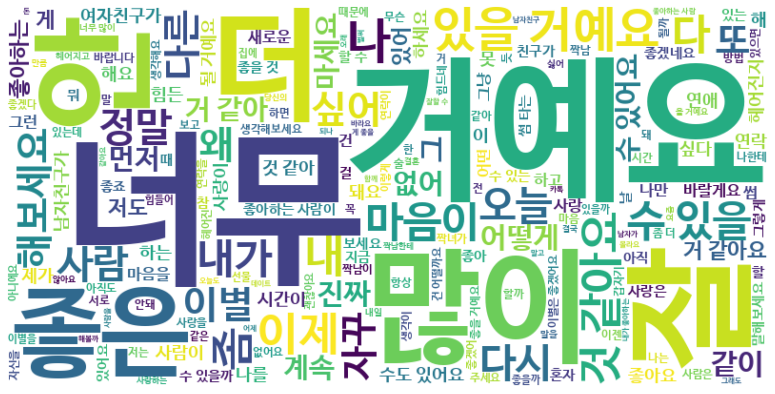

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from wordcloud import WordCloud

# 사용 가능한 폰트 리스트 출력
available_fonts = [font for font in fm.fontManager.ttflist if 'Nanum' in font.name or 'nanum' in font.name]

if available_fonts:
    chosen_font = available_fonts[0].fname  # 첫 번째 폰트의 파일명을 선택
    print("선택된 폰트:", chosen_font)

    # 워드 클라우드 생성 시 선택된 폰트를 지정
    wordcloud = WordCloud(font_path=chosen_font, width=800, height=400, background_color='white').generate(' '.join(all_words))
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
else:
    print("Nanum 폰트가 사용 가능한 폰트 리스트에 없습니다.")

# STEP 2. 데이터 전처리하기


### question & answer 데이터셋 으로 분리


In [ ]:
questions = train_data['Q'].tolist()  # 질문(Q) 컬럼을 리스트로 변환
answers = train_data['A'].tolist()  # 답변(A) 컬럼을 리스트로 변환

In [ ]:
# 처리 결과 확인
list(zip(questions, answers))[:5]

[('12시 땡!', '하루가 또 가네요.'),
 ('1지망 학교 떨어졌어', '위로해 드립니다.'),
 ('3박4일 놀러가고 싶다', '여행은 언제나 좋죠.'),
 ('3박4일 정도 놀러가고 싶다', '여행은 언제나 좋죠.'),
 ('PPL 심하네', '눈살이 찌푸려지죠.')]

## 토큰화 위한 처리

- 학습노드에서 했던 것처럼 기본적으로 구두점을 띄어쓰기 처리를 해줍니다.
- 몇가지 더 시도해보고 싶은 전처리가 있지만 이는 차후 모델 개선 파트에서 시도해보겠습니다.


- 구두점(예: ?, ., !)을 띄어쓰기와 함께 처리하는 이유는 다음과 같습니다

- 토큰화(Tokenization)

  - 구두점은 문장 내의 단어와 구절을 분리하는 역할을 합니다.
  - 따라서 구두점을 띄어쓰기와 함께 처리하면 문장을 단어 또는 토큰 단위로 쉽게 분할할 수 있습니다.

- 일관된 입력 데이터

  - 구두점 처리를 통해 입력 데이터를 일관된 형태로 만듭니다.
  - 예를 들어, "12시 땡!"과 "12시 땡 !"은 동일한 의미를 가지지만, 구두점 처리를 하지 않으면 이를 다른 문장으로 처리할 수 있습니다.
  - 따라서 구두점을 띄어쓰기와 함께 처리하여 입력 데이터의 일관성을 유지합니다.

- 모델 학습 편의성
  - 구두점 처리를 통해 모델이 문장을 이해하고 학습하기 쉬워집니다.
  - 구두점을 제대로 처리하지 않으면 모델이 문장의 의미를 정확하게 파악하는데 어려움을 겪을 수 있습니다.


In [ ]:
import re

# 질문(Q) 컬럼을 리스트로 변환하고 구두점에 대해 띄어쓰기 적용
questions = [re.sub(r"([?.!,])", r" \1 ", question) for question in questions]

# 답변(A) 컬럼을 리스트로 변환하고 구두점에 대해 띄어쓰기 적용
answers = [re.sub(r"([?.!,])", r" \1 ", answer) for answer in answers]

In [ ]:
# 처리 결과 확인
list(zip(questions, answers))[:5]

[('12시 땡 ! ', '하루가 또 가네요 . '),
 ('1지망 학교 떨어졌어', '위로해 드립니다 . '),
 ('3박4일 놀러가고 싶다', '여행은 언제나 좋죠 . '),
 ('3박4일 정도 놀러가고 싶다', '여행은 언제나 좋죠 . '),
 ('PPL 심하네', '눈살이 찌푸려지죠 . ')]

- 구두점들에 대해 전처리가 올바르게 된 것을 확인할 수 있습니다.


# STEP 3. SubwordTextEncoder 사용하기


- 한국어에 SubwordTextEncoder를 적용하면 여러가지 이점이 있습니다.

1. 풍부한 단어 표현

- SubwordTextEncoder는 단어를 하위 단위(subword)로 분해하는 기능을 합니다.
- 이는 언어의 다양한 표현 또는 한 단어 내에서의 다양한 의미와 변형을 토큰화 할 수 있습니다.
  - 예를들어 "사랑", "사랑하는", "사랑스러운" 같은 단어들은 subword로 분리될때 공통된 부분("사랑") 이 있고, 모델은 이런 다양한 표현속 공통점을 학습해 다양한 형태의 단어를 이해할 수 있습니다.

2. OOV(Out of Vocabulary) 완화

- 언어모델의 성능에는 어휘사전에 없는 단어를 어떻게 처리하는가도 중요한 요소입니다.
- SubwordTextEncoder를 사용하면 어휘 사전에 없는 단어를 하뒤 안뒤로 분해하여 처리하기 대문에 OOV문제를 완호할 수 있습니다.
- 즉, 입력값으로 새로운 단어나 변형된 단어가 나오더라도 모델이 이를 subword로 분해하여 학습이 가능하다는 의미입니다.


In [ ]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [ ]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8179]
종료 토큰 번호 : [8180]
단어 집합의 크기 : 8181


- START_TOKEN과 END_TOKEN의 값을 고려할때 최종 단어장의 크기는 +2가 되어 8181개가 됩니다.


## 각 단어에 정수 Encoding 및 패딩 적용

- 위에서 SubwordTextEncoder를 사용해 tokenizer를 정의하고 Vocabulary를 만들었습니다.
- 이제 생성한 Vocabs들은 encoding을 통해 정수로 변환되고, decoder를 통해 다시 단어 시퀀스로 변환이 가능합니다.
- 이를 샘플을 통해 확인해 보겠습니다.


### 샘플을 통한 Encoding 및 Decoding 결과 테스트


In [ ]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
sample_index = 21
encoded_question = tokenizer.encode(questions[sample_index])
encoded_answer = tokenizer.encode(answers[sample_index])

# 정수 인코딩 결과 출력
print('정수 인코딩 후의 {}번째 질문 샘플: {}'.format(sample_index, encoded_question))
print('정수 인코딩 후의 {}번째 답변 샘플: {}'.format(sample_index, encoded_answer))

# 디코딩 결과 출력
decoded_question = tokenizer.decode(encoded_question)
decoded_answer = tokenizer.decode(encoded_answer)

print('디코딩 후의 {}번째 질문 샘플: {}'.format(sample_index, decoded_question))
print('디코딩 후의 {}번째 답변 샘플: {}'.format(sample_index, decoded_answer))

정수 인코딩 후의 21번째 질문 샘플: [5767, 610, 2493, 4168]
정수 인코딩 후의 21번째 답변 샘플: [2357, 7518, 7, 6281, 97, 1]
디코딩 후의 21번째 질문 샘플: 가스비 장난 아님
디코딩 후의 21번째 답변 샘플: 다음 달에는 더 절약해봐요 . 


- 위의 결과에서 볼 수 있듯이, 각각의 문장이 정수로 인코딩되었습니다. 이 때, 서브워드 토큰들은 여러 개의 정수로 표현될 수 있습니다.

  - 예를 들어, "가스비"는 [5767]과 같이 한 개의 정수로 인코딩되고, "비싼데"는 [610]과 [2493]과 같이 두 개의 정수로 인코딩됩니다.

- 디코딩 후에는 정수로 표현된 서브워드들이 원래의 문장으로 복원되었습니다.
- 이러한 과정을 통해 모델은 인코딩된 정수 시퀀스를 디코딩하여 자연어 이해 및 생성 작업을 수행합니다.


### Encoding 및 Padding 적용

- 처음에는 학습노드때와 마찬가지로 최대길이(MAX_LENGTH)를 초과화는 샘플을 필터링 하여 제거하는 코드를 그대로 사용했습니다.
- 하지만 이번 데이터셋의 경우 **데이터의 길이가 대체로 짧은 편이라 이러한 적용을 하면 필터링 되는 데이터의 수가 1개밖에 되지 않습니다.**

---

- 길이 40이하의 데이터만 필터링한 후 패딩하는 코드(기존 노드 학습 코드)

```python
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs
```

![image](https://github.com/Kimgabe/AIFFEL_Online_Quest/assets/74717033/c4d7ae6f-0bcb-4357-84d5-1479c55969e0)

---

- 따라서 이번에는 모든 데이터셋을 살리기 위해 필터링 없이 모든 데이터셋에 대해 패딩을 적용하는 코드로 변경하여 사용합니다.


- 적절한 패딩의 길이를 설정하기 위해 데이터셋의 문장 길이 분포를 살펴보겠습니다.


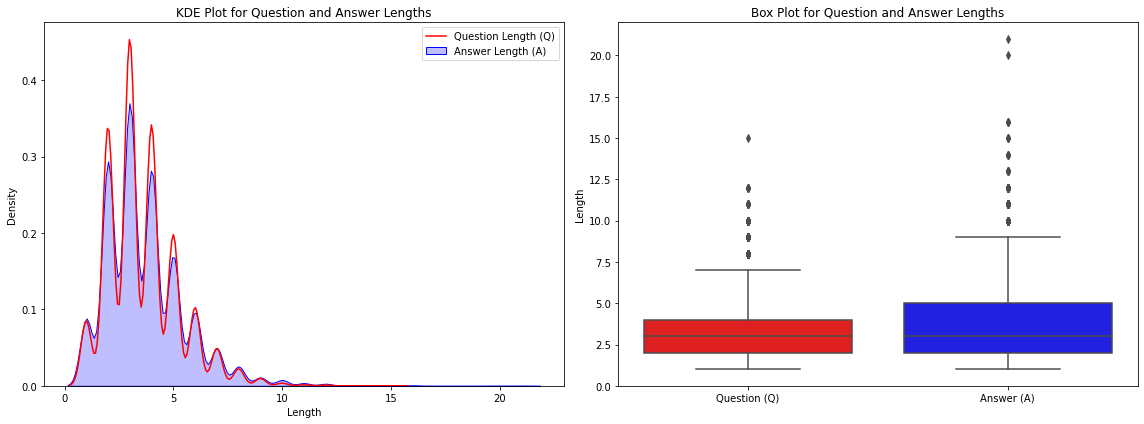

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터프레임에서 'Q'와 'A' 컬럼을 추출하여 각각의 길이를 구합니다.
question_lengths = [len(q.split()) for q in train_data['Q']]
answer_lengths = [len(a.split()) for a in train_data['A']]

# 캔버스 생성
plt.figure(figsize=(16, 6))

# KDE 그래프 (좌측) - Question(Q)와 Answer(A) 같이 그리기
plt.subplot(1, 2, 1)
sns.kdeplot(question_lengths, color='red', label='Question Length (Q)', fill=False)
sns.kdeplot(answer_lengths, color='blue', label='Answer Length (A)', fill=True)
plt.title('KDE Plot for Question and Answer Lengths')
plt.xlabel('Length')
plt.ylabel('Density')
plt.legend()

# Boxplot 그래프 (우측) - Question(Q)와 Answer(A) 같이 그리기
plt.subplot(1, 2, 2)
sns.boxplot(data=[question_lengths, answer_lengths], palette=['red', 'blue'])
plt.title('Box Plot for Question and Answer Lengths')
plt.ylabel('Length')
plt.xticks([0, 1], ['Question (Q)', 'Answer (A)'])

# 그래프 표시
plt.tight_layout()
plt.show()

- 대부분의 문장 길이가 10 내외에 머무릅니다.
- boxpolot으로 봐도 최대 길이는 약 20정도가 되는 것 같습니다.
  - EDA단계에서 확인했던 MAX값은 21이었으므로 패딩 기준을 25로 적용해도 적당할 것입니다.
  - 하지만, 학습한 문장에 대해서만 답변을 생성할 것이 아니라 새로운 문장에 대해서도 생성할 수 있는 챗봇이 되어야 하므로 넉넉하게 40으로 패딩사이즈를 설정하겠습니다.


In [ ]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40

# 정수 인코딩, 최대 길이로 패딩
def tokenize_and_pad(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [ ]:
questions, answers = tokenize_and_pad(questions, answers)


print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))
print('필터링 후 질문 데이터의 크기(shape) :', questions.shape)
print('필터링 후 답변 데이터의 크기(shape) :', answers.shape)

단어장의 크기 : 8181
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823
필터링 후 질문 데이터의 크기(shape) : (11823, 40)
필터링 후 답변 데이터의 크기(shape) : (11823, 40)


- 올바르게 기존 데이터셋의 볼륨을 모두 유지하면서 패딩은 40으로 처리된 데이터를 확보 했습니다.


## 데이터 파이프라인 구축

- tf.data.Dataset API 는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API입니다.
- 이때 decoder의 input과 label(실제값) 을 정의해주기 위해 Teach Forcing이라는 언어모델 훈련기법이 적용됩니다.

- 질문과 답변을 한쌍으로 하여 데이터셋을 구성하는 파이프라인을 구성합니다.
- 이때 Teacher Forcing을 사용하기 위해 Decoder의 입력과 실제값의 시퀀스를 구성합니다.

---

- Teacher Forcing은 원래 RNN이나 Seq2Seq 모델들의 경우 Teacher Forcing을 사용하지 않는 경우 잘못된 예측이 축적되고 이로 인해 비효율적인 학습과정이 반복되어 모델 성능이 악화 되는 문제가 있습니다.
  - 특히, 초기에 이런 오류가 발생하면 모델이 효율적인 학습을 하지 못합니다.
- Teacher Forcing을 적용하면 모델의 입력이 현재 시간 단계의 실제 정답으로 고정되어 이러한 문제를 해결하고 좀 더 안정적으로 학습이 가능합니다.

---

### 트랜스포머 모델에 Teacher Forcing을 적용하는 이유⁉️

- 트랜스포머 모델의 경우 전체 입력 시퀀스를 한번에 처리하기 때문에 RNN이나 Seq2Seq에서 마주하는 문제들에서는 상대적으로 자유롭습니다.
- 그럼에도 불구하고 트랜스포머 모델에 Teacher Forcing을 적용하는 이유는 아래와 같습니다.
- 1. 병렬처리 효율성
  - 트랜스포머 모델의 특성상 전체 시퀀스를 한번에 (병렬)처리 하므로 각 타임 스텝마다 정확한 타켓을 참조하며 학습합니다.
  - 즉, 각 스텝별로 모델이 올바른 출력을 예측하는 방법을 더 빠르게 학습할 수 있습니다.
- 2. 데이터 효율성 증가
  - Teacher Forcing으로 올바른 출력에 대한 방법을 빠르게 학습하기 때문에 상대적으로 누적되는 오류가 줄어들고, 동일한 성능 달성을 위해 필요한 데이터의 양이 감소해 효율적인 학습이 가능합니다
- 3. 정확도 향상
  - 위의 두가지 이유로 모델은 각 타임스텝에서 실제 타겟과의 오차를 줄이면서 학습합니다.
  - 이로인해 모델이 실제 데이터 분포를 더 정확하게 학습하고, 따라서 더 정확한 예측을 할 수 있게 됩니다.


In [ ]:
BATCH_SIZE = 64  # 배치 크기 설정
BUFFER_SIZE = 20000  # 데이터를 섞을 버퍼 크기 설정 (데이터셋보다 크게 설정)

# 디코더의 입력과 출력 데이터셋 구성
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,  # 입력 데이터로 질문을 사용
        'dec_inputs': answers[:, :-1]  # 디코더의 입력 데이터로 이전 답변의 일부를 사용 (START_TOKEN 제외)
    },
    {
        'outputs': answers[:, 1:]  # 디코더의 출력 데이터로 실제 답변의 일부를 사용 (END_TOKEN 제외)
    },
))

dataset = dataset.cache()  # 데이터 캐싱
dataset = dataset.shuffle(BUFFER_SIZE)  # 버퍼 크기만큼 데이터셋을 섞음
dataset = dataset.batch(BATCH_SIZE)  # 배치 크기에 맞게 데이터셋을 배치화
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)  # 데이터 미리 로딩 설정

# STEP 4. 모델 구성하기


## 벡터화 및 Attention 관련 코드 구현


### Positional Encoding 구현


In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        # 위치 인코딩을 계산합니다. position은 시퀀스의 최대 길이, d_model은 모델의 차원입니다.
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        # 빈 딕셔너리를 리턴하는 메서드입니다. 모델 저장 시 필요한 메서드 중 하나입니다.
        return {}

    def call(self, inputs):
        # 입력에 위치 인코딩을 더해주는 메서드입니다.
        return inputs + self.pos_encoding

    def get_angles(self, position, i, d_model):
        # 각도를 계산하는 함수입니다. position은 위치, i는 인덱스, d_model은 모델의 차원을 나타냅니다.
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각 위치에 대한 각도 값을 계산합니다.
        angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

        # 짝수 인덱스에는 사인 함수를 적용하여 위치 인코딩을 생성합니다.
        sines = tf.math.sin(angle_rads[:, 0::2])

        # 홀수 인덱스에는 코사인 함수를 적용하여 위치 인코딩을 생성합니다.
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # 사인과 코사인 값을 번갈아가면서 할당하여 위치 인코딩을 생성합니다.
        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines

        # 위치 인코딩을 텐서로 변환하고 차원을 확장합니다.
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        # 위치 인코딩의 모양을 출력합니다.
        print(pos_encoding.shape)
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        # 입력 텐서에 위치 인코딩을 더하여 반환합니다.
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Scaled Dot Production Attention 구현


In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, key의 문장 길이)

    # Q와 K의 곱. 어텐션 스코어 행렬을 얻습니다.
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 스케일링: 스케일링은 어텐션 스코어 행렬을 dk(d_model/num_heads의 루트값)로 나눠줍니다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 마스킹: 어텐션 스코어 행렬의 특정 위치에 매우 작은 음수값을 더해 마스킹을 수행합니다.
    # 이렇게 하면 해당 위치의 어텐션 가중치가 0이 됩니다.
    if mask is not None:
        logits += (mask * -1e9)

    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행됩니다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)

    return output, attention_weights

### Multi Head Attention 구현


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        # d_model을 num_heads로 나눈 값.
        # 논문 기준 : 64
        self.depth = d_model // self.num_heads

        # WQ, WK, WV에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)

    # 레이어 설정 모델 저장용
    def get_config(self):
        return {"num_heads": self.num_heads, "d_model": self.d_model}

    # num_heads 개수만큼 q, k, v를 split하는 함수
    def split_heads(self, inputs, batch_size):
        # 입력 텐서(inputs)를 형태를 재구성합니다.
        # 형태 재구성 후의 크기는 (batch_size, num_heads, 문장 길이, d_model/num_heads)
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))

        # 텐서를 전치(transpose)하여 어텐션 헤드를 제대로 나눕니다.
        # 전치 후의 크기는 (batch_size, num_heads, 문장 길이, d_model/num_heads)
        return tf.transpose(inputs, perm=[0, 2, 1, 3])


    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 1. WQ, WK, WV에 해당하는 밀집층 지나기
        # q : (batch_size, query의 문장 길이, d_model)
        # k : (batch_size, key의 문장 길이, d_model)
        # v : (batch_size, value의 문장 길이, d_model)
        # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있음
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 헤드 나누기
        # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. 헤드 연결(concatenate)하기
        # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention,
                                    (batch_size, -1, self.d_model))

        # 5. WO에 해당하는 밀집층 지나기
        # (batch_size, query의 문장 길이, d_model)
        outputs = self.dense(concat_attention)

        return outputs

## Encoder 관련 기능 구현


### Padding Mask 구현


In [ ]:
def create_padding_mask(x):
    # 입력 텐서 x에서 값이 0인 위치를 찾아 boolean 마스크로 변환
    # 이 때, 값이 0인 위치는 True로, 그렇지 않은 위치는 False로 표시
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)

    # 반환되는 마스크의 모양은 (batch_size, 1, 1, key의 문장 길이)
    # 이렇게 하면 어텐션 연산 시 패딩 토큰에 대한 가중치가 0이 되어 패딩을 무시할 수 있음
    return mask[:, tf.newaxis, tf.newaxis, :]

### Encoder layer 구성


In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
            'mask': padding_mask # 패딩 마스크 사용
        })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Encoder 구성


In [ ]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 포지셔널 인코딩 + 드롭아웃
    # Embedding 레이어를 사용하여 입력 토큰을 임베딩 벡터로 변환
    # vocab_size는 어휘 사전 크기를 나타내고, d_model은 임베딩 차원
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)

    # 임베딩 벡터에 루트 d_model로 스케일링
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩(Positional Encoding)을 추가
    # 이것은 입력에 문장의 위치 정보를 추가하는 역할
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # 드롭아웃(Dropout)을 적용하여 학습 중 과적합을 방지
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)


    # 인코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
            dropout=dropout, name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

## Decoder 관련 기능 구현


### Look ahead mask 함수


In [ ]:
# 디코더의 첫 번째 서브층(sublayer)에서 미래 토큰을 가리는 마스크를 생성
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]

    # 룩어헤드 마스크(look-ahead mask)를 생성
    # 이 마스크는 행렬의 주 대각선 아래쪽을 0으로 만듬
    # 즉, 각 위치에서 현재 및 과거 토큰에만 접근 가능하도록 함
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

    # 패딩 마스크(padding mask)도 함께 고려하여 최종 마스크를 생성
    padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
    return tf.maximum(look_ahead_mask, padding_mask)

### Decoder Layer 구성


In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    # 디코더 레이어의 입력
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 인코더의 출력(인코더-디코더 어텐션에 사용)
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
            'mask': look_ahead_mask # 룩어헤드 마스크
        })

    # 잔차 연결과 층 정규화
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
            'mask': padding_mask # 패딩 마스크
        })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

### Decoder 구성


In [ ]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):

    # 디코더의 입력. 모델에 입력할 데이터의 형태를 정의
    # shape=(None,)는 가변적인 길이의 시퀀스를 의미하며, inputs는 입력 데이터의 이름
    inputs = tf.keras.Input(shape=(None,), name='inputs')

    # 인코더의 출력. 이전 단계에서 인코더의 출력이 디코더로 전달됨
    # shape=(None, d_model)은 가변적인 길이의 시퀀스와 임베딩 차원 d_model을 나타냄
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 포지셔널 인코딩 + 드롭아웃
    # 임베딩 레이어를 사용하여 입력 문장을 임베딩 벡터로 변환
    # vocab_size는 어휘 사전의 크기, d_model은 임베딩 차원
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)

    # 임베딩 벡터에 스케일링 요인을 곱하여 모델이 더 잘 학습하도록 도와줌
    # 이 스케일링 요인은 임베딩 차원에 루트를 씌운 값으로 스케일링됨
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩을 추가 이것은 문장의 위치 정보를 임베딩 벡터에 더해줌
    # PositionalEncoding 클래스를 사용하여 수행됨
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # 드롭아웃을 적용
    # 이를 통해 학습 중에 임의의 뉴런을 비활성화시키고 모델을 일반화함
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
            dropout=dropout, name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

## Transformer 모델 구현


In [ ]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):
    # 인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더의 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 디코더의 패딩 마스크(두번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
        d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])  # 인코더의 입력은 입력 문장과 패딩 마스크

    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
        d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 다음 단어 예측을 위한 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

(1, 9000, 128)
(1, 9000, 128)


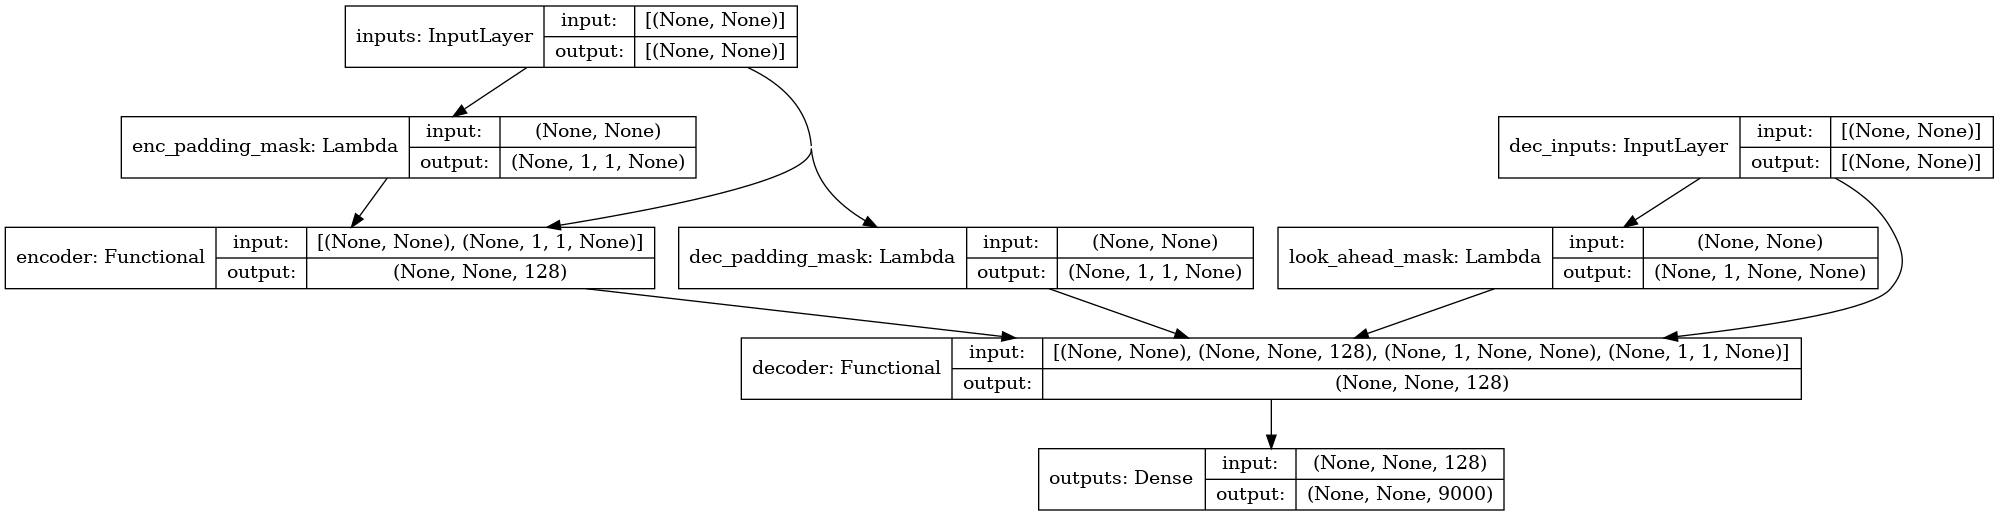

In [ ]:
# (논문대비) 간소화된 버전의 Transformer 모델 생성
small_transformer = transformer(
    vocab_size=9000,
    num_layers=4,
    dff=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="small_transformer")

# 모델 구조 시각화 및 이미지 파일로 저장
tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

### Custom Learnig rate 구성하기

- 모델학습을 안정적으로 하기위해 최근에 가장 보편적으로 사용되는것은 학습초기에 Learning rate를 급격히 높게 설정하고, train step 마다 점진적으로 낮춰가면서 안정적인 수렴을 유도하는 방법입니다.

- 이를 Custom Learning rate Sechduling 이라합니다.
- [Transformer 논문](https://arxiv.org/abs/1706.03762) 에 언급된 공식을 그대로 사용해 코드로 구현합니다.

$$
\text{lr} = d_{\text{model}}^{-0.5} \cdot \min(\text{step\_num}^{-0.5}, \text{step\_num} \cdot \text{warmup\_steps}^{-1.5})
$$


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model  # 모델의 차원 수
        self.d_model = tf.cast(self.d_model, tf.float32)  # d_model을 부동 소수점으로 변환
        self.warmup_steps = warmup_steps  # 웜업 단계 수

    def __call__(self, step):
        # 스텝(step)에 따라 학습률을 조정하는 함수
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        # 커스텀 학습률 스케줄링 수식을 계산하여 학습률을 반환합니다.
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

- 구현된 학습률의 변화를 시각화 하면 아래와 같습니다.


Text(0.5, 0, 'Train Step')

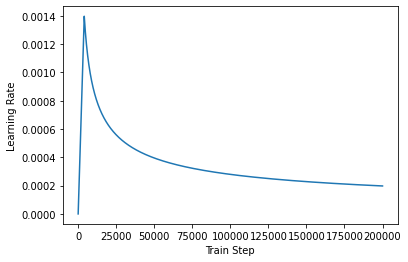

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 모델 구축


In [ ]:
# TensorFlow 세션 초기화
tf.keras.backend.clear_session()

# 하이퍼파라미터 설정
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1
# UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기(모델 성능 & 복잡도 설정)

# 트랜스포머 모델 생성
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 8181, 256)
(1, 8181, 256)


### 손실함수 생성


In [ ]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    # Sparse Categorical Crossentropy 손실 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    # 패딩된 부분에 대한 손실을 제거하기 위한 마스크 생성
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    # 마스크를 적용한 평균 손실 계산
    return tf.reduce_mean(loss)

### 모델 컴파일


In [ ]:
# Learning Rate 스케줄링 설정
learning_rate = CustomSchedule(D_MODEL)

# Adam 옵티마이저 설정
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 정확도 함수 정의
def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# 모델 컴파일
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("모델 컴파일 완료")

모델 컴파일 완료


### 모델 훈련


In [ ]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 17s 55ms/step - loss: 1.4533 - accuracy: 0.0196
Epoch 2/50
185/185 [==============================] - 10s 55ms/step - loss: 1.1789 - accuracy: 0.0482
Epoch 3/50
185/185 [==============================] - 10s 56ms/step - loss: 1.0025 - accuracy: 0.0509
Epoch 4/50
185/185 [==============================] - 10s 55ms/step - loss: 0.9276 - accuracy: 0.0546
Epoch 5/50
185/185 [==============================] - 10s 55ms/step - loss: 0.8685 - accuracy: 0.0578
Epoch 6/50
185/185 [==============================] - 10s 55ms/step - loss: 0.8091 - accuracy: 0.0618
Epoch 7/50
185/185 [==============================] - 10s 55ms/step - loss: 0.7438 - accuracy: 0.0678
Epoch 8/50
185/185 [==============================] - 10s 55ms/step - loss: 0.6712 - accuracy: 0.0754
Epoch 9/50
185/185 [==============================] - 10s 55ms/step - loss: 0.5930 - accuracy: 0.0837
Epoch 10/50
185/185 [==============================] - 10s 55ms/step - loss: 0.511

In [ ]:
import os
from datetime import datetime

# 모델 저장 경로
MODEL_DIR = './saved_models/'

def save_model(model):
    # 현재 시간을 기준으로 모델 파일명 생성 (시간 접미사 추가)
    current_time = datetime.now().strftime("%Y%m%d%H%M%S")
    model_filename = f'model_{current_time}.h5'
    model_path = os.path.join(MODEL_DIR, model_filename)

    # 모델 저장
    model.save(model_path)
    print(f"모델이 {model_path}에 저장되었습니다.")

def load_model(model_index):
    # 저장된 모델 파일 목록 가져오기
    model_files = os.listdir(MODEL_DIR)

    # 시간 접미사를 기준으로 모델 파일 목록 정렬
    sorted_model_files = sorted(model_files, key=lambda x: int(x.split('_')[-1]))

    if 0 <= model_index < len(sorted_model_files):
        selected_model_path = os.path.join(MODEL_DIR, sorted_model_files[model_index])

        # 모델 불러오기
        loaded_model = tf.keras.models.load_model(selected_model_path)
        print(f"{selected_model_path} 모델을 불러왔습니다.")
        return loaded_model
    else:
        print("유효한 모델 번호를 선택해주세요.")
        return None

# 모델 저장 예시
save_model(model)

# 모델 불러오기 예시
# loaded_model = load_model(selected_model_index)

NotImplementedError: Layer MultiHeadAttention has arguments in `__init__` and therefore must override `get_config`.

# STEP 5. 모델 평가하기

- STEP 2. 에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.
- 최초 시도에는 문자와 구두점을 띄어쓰기 처리하는 아래의 코드만을 적용했었습니다.

```python
# 질문(Q) 컬럼을 리스트로 변환하고 구두점에 대해 띄어쓰기 적용
questions = [re.sub(r"([?.!,])", r" \1 ", question) for question in questions]

# 답변(A) 컬럼을 리스트로 변환하고 구두점에 대해 띄어쓰기 적용
answers = [re.sub(r"([?.!,])", r" \1 ", answer) for answer in answers]
```

- 따라서 챗봇에 텍스트를 입력할때도 동일한 처리가된 문장이 입력되도록 해야 합니다.


### 입력문장에 전처리 적용하는 함수 구현


In [ ]:
def preprocess_sentence(sentence):
    # 구두점에 대해 띄어쓰기 적용
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 여러 개의 공백을 하나의 공백으로 대체
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 문장 앞뒤 공백 제거
    sentence = sentence.strip()
    return sentence

In [ ]:
def decoder_inference(sentence):

    # 챗봇 입력 시퀀스에 학습데이터와 동일한 전처리 적용
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, START_TOKEN & END_TOKEN 앞뒤로 추가
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis = 0)

    # Decoder의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수
    # 첫 스텝에서는 예측 내용이 없으므로 START_TOKEN만 별도 저장
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # Decoder의 Inference 단계
    for i in range(MAX_LENGTH): # 25로 설정했었음
        # Decoder는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복
        predictions = model(inputs = [sentence, output_sequence], training = False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis = -1), tf.int32)

        # if 현재 예측한 단어가 END_TOKEN이라면 for문 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가
        # 추가된 output_sequene는 다시 Decoder의 입력으로 전달
        output_sequence = tf.concat([output_sequence, predicted_id], axis = -1)

    return tf.squeeze(output_sequence, axis = 0)

In [ ]:
def sentence_generation(sentence):
    # 입력 문장에 대해 Decoder를 동장시켜 예측된 정수 시퀀스를 return 받음
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    # 결과 출력
    print('원본 데이터셋 Pair')
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(sentence))
    print('-'*20)

    return predicted_sentence

### 샘플데이터 문장 입력하여 답변 확인

- 데이터셋의 head 부분 5개 문장에 대한 답변을 확인합니다.


In [ ]:
sentence_generation('12시 땡!')

원본 데이터셋 Pair
입력 : 12시 땡!
출력 : 12시 땡!
--------------------


'하루가 또 가네요 . '

In [ ]:
sentence_generation('1집망 학교 떨어졌어')

원본 데이터셋 Pair
입력 : 1집망 학교 떨어졌어
출력 : 1집망 학교 떨어졌어
--------------------


'위로해 드립니다 . '

In [ ]:
sentence_generation('3박4일 놀러가고 싶다.')

원본 데이터셋 Pair
입력 : 3박4일 놀러가고 싶다.
출력 : 3박4일 놀러가고 싶다.
--------------------


'여행은 언제나 좋죠 . '

In [ ]:
sentence_generation('3박4일 정도 놀러가고 싶다.')

원본 데이터셋 Pair
입력 : 3박4일 정도 놀러가고 싶다.
출력 : 3박4일 정도 놀러가고 싶다.
--------------------


'여행은 언제나 좋죠 . '

In [ ]:
sentence_generation('PPL 심하네')

원본 데이터셋 Pair
입력 : PPL 심하네
출력 : PPL 심하네
--------------------


'눈살이 찌푸려지죠 . '

### 랜덤 샘플 추출하여 답변 확인


In [ ]:
import random

questions_samples = train_data['Q'].to_list()
answers_samples = train_data['A'].to_list()

# questions와 answers 리스트가 있다고 가정할 때,
random_pairs = random.sample(list(zip(questions_samples, answers_samples)), 10)
print(random_pairs)

[('오늘도 계속 생각나네', '언제쯤 그분 생각에 자유로워질까요.'), ('너무 답답한데.', '여행을 떠나 보세요.'), ('공복이라 예민해', '자연스러운 현상이에요.'), ('여사친인데 좋아하는 듯.', '친구와 썸의 중간인 거 같아요.'), ('두번째 이별', '이별은 언제나 힘들어요.'), ('후.ㅎㅎ', '지쳤나봐요.'), ('썸일 때도 스킨십 하고 싶어?', '자연스러운 현상이에요.'), ('나 폰겜했더니 몇 시간 갔어', '시간을 정해보세요.'), ('연애 초보다 연락을 너무 안해', '편해진 것 같네요.'), ('시간이 휘리릭', '시간은 상대적이죠.')]


In [ ]:
# random_pairs 리스트를 iteration하면서 sentence_generation 함수를 적용
for q, a in random_pairs:
    print('-'*20)
    print("입력한 문장: ", q)
    print('-'*20)
    print("생성된 답변: \n")
    print(sentence_generation(q))
    print()

--------------------
입력한 문장:  오늘도 계속 생각나네
--------------------
생성된 답변: 

원본 데이터셋 Pair
입력 : 오늘도 계속 생각나네
출력 : 오늘도 계속 생각나네
--------------------
언제쯤 그분 생각에 자유로워질까요 . 

--------------------
입력한 문장:  너무 답답한데.
--------------------
생성된 답변: 

원본 데이터셋 Pair
입력 : 너무 답답한데.
출력 : 너무 답답한데.
--------------------
여행을 떠나 보세요 . 

--------------------
입력한 문장:  공복이라 예민해
--------------------
생성된 답변: 

원본 데이터셋 Pair
입력 : 공복이라 예민해
출력 : 공복이라 예민해
--------------------
자연스러운 현상이에요 . 

--------------------
입력한 문장:  여사친인데 좋아하는 듯.
--------------------
생성된 답변: 

원본 데이터셋 Pair
입력 : 여사친인데 좋아하는 듯.
출력 : 여사친인데 좋아하는 듯.
--------------------
친구와 썸의 중간인 거 같아요 . 

--------------------
입력한 문장:  두번째 이별
--------------------
생성된 답변: 

원본 데이터셋 Pair
입력 : 두번째 이별
출력 : 두번째 이별
--------------------
이별은 언제나 힘들어요 . 

--------------------
입력한 문장:  후.ㅎㅎ
--------------------
생성된 답변: 

원본 데이터셋 Pair
입력 : 후.ㅎㅎ
출력 : 후.ㅎㅎ
--------------------
지쳤나봐요 . 

--------------------
입력한 문장:  썸일 때도 스킨십 하고 싶어?
--------------------
생성된 답변: 

원본 데이터셋 Pair
입력 : 썸일 때

### 학습하지 않은 문장에 대한 답변 확인


In [ ]:
sentence_generation('12시인데 배가 너무 고파')

원본 데이터셋 Pair
입력 : 12시인데 배가 너무 고파
출력 : 12시인데 배가 너무 고파
--------------------


'하루가 또 가네요 . '

In [ ]:
sentence_generation('이 드라마는 PPL이 너무 심한거 같아')

원본 데이터셋 Pair
입력 : 이 드라마는 PPL이 너무 심한거 같아
출력 : 이 드라마는 PPL이 너무 심한거 같아
--------------------


'눈살이 찌푸려지죠 . '

In [ ]:
sentence_generation('여자친구랑 헤어졌는데 너무 슬퍼')

원본 데이터셋 Pair
입력 : 여자친구랑 헤어졌는데 너무 슬퍼
출력 : 여자친구랑 헤어졌는데 너무 슬퍼
--------------------


'후회안할 자신 있다면 연락해보세요 . '

In [ ]:
sentence_generation('읽을만한 책을 추천해줄래?')

원본 데이터셋 Pair
입력 : 읽을만한 책을 추천해줄래?
출력 : 읽을만한 책을 추천해줄래?
--------------------


'바쁘면 좋을거죠 . '

In [ ]:
sentence_generation('나 오늘 헤어짐')

원본 데이터셋 Pair
입력 : 나 오늘 헤어짐
출력 : 나 오늘 헤어짐
--------------------


'자책하지 말아요 . '

In [ ]:
sentence_generation('15박 16일정도 쉴수있었으면 좋겠다.')

원본 데이터셋 Pair
입력 : 15박 16일정도 쉴수있었으면 좋겠다.
출력 : 15박 16일정도 쉴수있었으면 좋겠다.
--------------------


'그런 날이 있더라고요 . '

In [ ]:
sentence_generation('15박16일 놀러가고 싶다.')

원본 데이터셋 Pair
입력 : 15박16일 놀러가고 싶다.
출력 : 15박16일 놀러가고 싶다.
--------------------


'그게 좋죠 . '

## 종합 평가 결과

- 딥러닝 기반의 대화형 챗봇 모델의 성능 평가에는 주로 BLEU, ROUGE, METEOR 등의 자동 평가 지표가 사용됩니다.
- 다만, 챗봇의 경우 특성상 봇의 응답이 문맥적으로 적절하고, 자연스럽며, 사용자의 질문에 잘 대응하는지 등을 평가하기 위해서는 사람의 평가가 필요합니다.
  - 이를 위해서는 휴먼 평가(Human Evaluation)를 진행할 수 밖에 없었습니다.

---

- Human Evaluation을 시도해본 결과, 학습한 문장에 대해서는 꽤 우수한 성능을 보여줍니다.
- 하지만 학습하지 않은 문장에 대해서는 다소 어색한 결과를 보여주기도 합니다.
- 다양한 성능 개선 시도를 통해 모델 성능을 더 향상시키도록 해보겠습니다.


# STEP 6. 모델 성능 개선시도

- 가장 보편적으로 시도할 수 있는 Transformer 모델의 성능 개선 방법은 아래와 같습니다.

**1. 데이터 확장 및 정제:**

- 데이터셋 확장: 더 다양하고 방대한 훈련 데이터를 사용하여 모델의 일반화 능력을 향상시킬 수 있습니다.
- 데이터 정제: 오류가 있는 데이터를 정제하고, 더 깨끗하고 일관된 데이터로 훈련시키면 모델의 성능이 향상될 수 있습니다.

**2. 하이퍼파라미터 조정:**

- 레이어 수, 히든 유닛 수, 학습률 등의 하이퍼파라미터를 조정하여 모델의 성능을 최적화할 수 있습니다.

**3. 정규화 및 드롭아웃 조정:**

- 오버피팅을 방지하기 위해 드롭아웃 비율을 조정할 수 있습니다.
  - 현재 드롭아웃비율은 0.1입니다.
- 레이어 정규화 방법을 변경하거나 추가하여 모델의 안정성을 높일 수 있습니다.

**4. Attention mechanism 개선:**

- Multi-Ahead attention의 구조를 변경하거나, Attention mechanism의 변형을 적용하여 성능을 향상시킬 수 있습니다.
- 예를 들어, Scaled Dot-product attention외에 다른 어텐션 기법을 시도해 볼 수 있습니다.

**5. 토크나이저 및 어휘집 개선:**

- 사용하는 토크나이저를 변경하거나, 어휘집을 최신화하고 확장하여 모델이 더 다양한 단어를 이해할 수 있도록 할 수 있습니다.
  - 현재 모델에 사용된 토크나이저는 SubwordTextEncoder 입니다.

**6. 트랜스퍼 러닝 및 파인튜닝:**

- 이미 훈련된 모델을 기반으로 추가적인 트레이닝을 수행하여 특정 도메인에 대한 모델의 성능을 향상시킬 수 있습니다.


---

- 가급적 Transformer의 논문에 게시된 구조를 유지하면서 성능을 높이고 싶어서 일반적인 파라미터들에 대해서는 크게 조정할 요소가 없어 보입니다.
- 시도해보고 싶은것중 하나는 데이터 증강과 추가 데이터 확보입니다.
- 일단은 추가적인 데이터를 확보(AI HUB 데이터셋 활용) 하여 이를 추가 학습시켜 모델 성능 향상을 시도해보겠습니다.
- 성능개선이 보인다면, 번역기를 활용한 데이터 증강을 통해 추가적인 성능 향상 시도도 해보고자 합니다.


## 추가 데이터 학습

- [AI HUB 웰니스 대화 스크립트 데이터셋](https://aihub.or.kr/aihubdata/data/view.do?currMenu=120&topMenu=100&aihubDataSe=extrldata&dataSetSn=267) 을 사용합니다.
- 강남 세브란스에서 전달받은 상담데이터 1만 6천건에서 초진이고 환자 본인이 직접 내원한 경우인 4200건에 대한 데이터셋입니다.
- 챗봇학습에 사용가능한 부분을 이용해 추가 데이터셋을 구축합니다.


### 데이터 불러오기 및 EDA


In [3]:
# Excel 파일을 불러오기
#file_path = '웰니스_대화_스크립트_데이터셋.xlsx'
file_path = '/content/웰니스_대화_스크립트_데이터셋.xlsx'
new_train_data = pd.read_excel(file_path)

# '유저' 컬럼을 'Q'로, '챗봇' 컬럼을 'A'로 이름 변경
new_train_data = new_train_data.rename(columns={'유저': 'Q', '챗봇': 'A'})
new_train_data = new_train_data.drop(columns=[new_train_data.columns[0]])


# 데이터의 처음 몇 개 행 확인
new_train_data.head()

,Q,A
0,제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.,감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.
1,더 이상 내 감정을 내가 컨트롤 못 하겠어.,저도 그 기분 이해해요. 많이 힘드시죠?
2,하루종일 오르락내리락 롤러코스터 타는 기분이에요.,"그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요."
3,꼭 롤러코스터 타는 것 같아요.,NaN
4,롤러코스터 타는 것처럼 기분이 왔다 갔다 해요.,NaN


- 유저컬럼과 챗봇 컬럼을 Q, A로 변경하고 원본 데이터와 마찬가지로 간단한 EDA를 시도해보겠습니다.


In [ ]:
# 기본 정보 출력
print("Chatbot 샘플 개수:")
print(len(new_train_data))
print("\n결측치 수:")
print(new_train_data.isnull().sum())

Chatbot 샘플 개수:
5231

결측치 수:
Q       0
A    4197
dtype: int64


In [ ]:
# 결측값을 제거하고 문자열 데이터만을 가지고 있는 행만 선택
new_train_data = new_train_data.dropna(subset=['A'])
new_train_data.loc[:, 'Q_length'] = new_train_data['Q'].apply(lambda x: len(x.split()))
new_train_data.loc[:, 'A_length'] = new_train_data['A'].apply(lambda x: len(x.split()))
print("\n질문 길이 통계:\n", new_train_data['Q_length'].describe())
print("\n답변 길이 통계:\n", new_train_data['A_length'].describe())


질문 길이 통계:
 count    1034.000000
mean        7.917795
std         3.446734
min         2.000000
25%         5.000000
50%         7.000000
75%        10.000000
max        22.000000
Name: Q_length, dtype: float64

답변 길이 통계:
 count    1034.000000
mean        7.766925
std         3.156583
min         1.000000
25%         5.250000
50%         8.000000
75%        10.000000
max        17.000000
Name: A_length, dtype: float64


선택된 폰트: /usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf


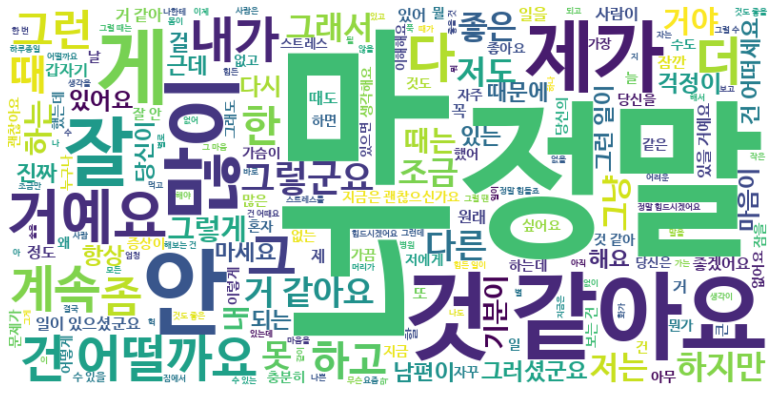

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from wordcloud import WordCloud

# 사용 가능한 폰트 리스트 출력
available_fonts = [font for font in fm.fontManager.ttflist if 'Nanum' in font.name or 'nanum' in font.name]

if available_fonts:
    chosen_font = available_fonts[0].fname  # 첫 번째 폰트의 파일명을 선택
    print("선택된 폰트:", chosen_font)

    # 워드 클라우드 생성 시 선택된 폰트를 지정
    wordcloud = WordCloud(font_path=chosen_font, width=800, height=400, background_color='white').generate(' '.join(all_words))
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
else:
    print("Nanum 폰트가 사용 가능한 폰트 리스트에 없습니다.")

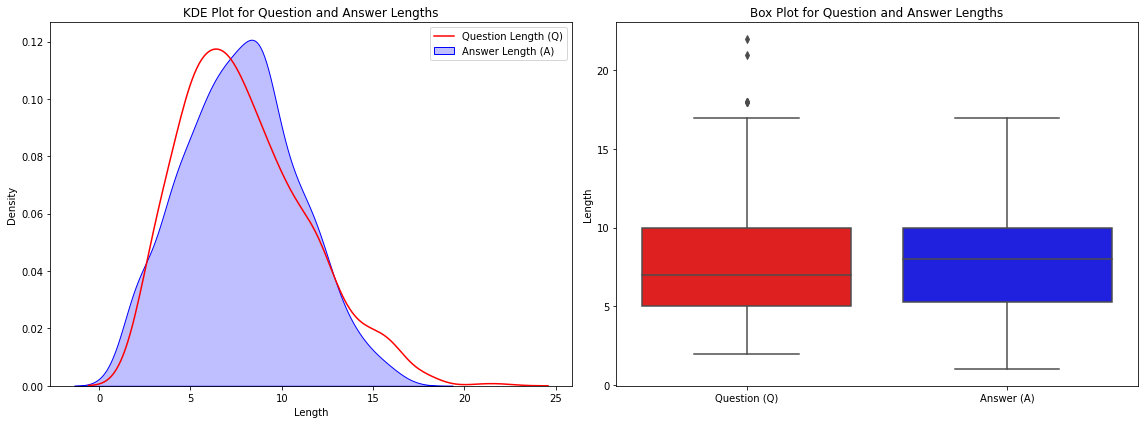

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터프레임에서 'Q'와 'A' 컬럼을 추출하여 각각의 길이를 구합니다.
question_lengths = [len(q.split()) for q in new_train_data['Q']]
answer_lengths = [len(a.split()) for a in new_train_data['A']]

# 캔버스 생성
plt.figure(figsize=(16, 6))

# KDE 그래프 (좌측) - Question(Q)와 Answer(A) 같이 그리기
plt.subplot(1, 2, 1)
sns.kdeplot(question_lengths, color='red', label='Question Length (Q)', fill=False)
sns.kdeplot(answer_lengths, color='blue', label='Answer Length (A)', fill=True)
plt.title('KDE Plot for Question and Answer Lengths')
plt.xlabel('Length')
plt.ylabel('Density')
plt.legend()

# Boxplot 그래프 (우측) - Question(Q)와 Answer(A) 같이 그리기
plt.subplot(1, 2, 2)
sns.boxplot(data=[question_lengths, answer_lengths], palette=['red', 'blue'])
plt.title('Box Plot for Question and Answer Lengths')
plt.ylabel('Length')
plt.xticks([0, 1], ['Question (Q)', 'Answer (A)'])

# 그래프 표시
plt.tight_layout()
plt.show()

- 추가 데이터셋의 경우도 문장의 길이가 max 22정도 입니다.
- 따라서 기존과 마찬가지로 MAX_LENGTH를 40정도로 설정해도 괜찮을 것 같습니다.


### 전처리 및 데이터셋 구축


In [ ]:
questions = new_train_data['Q'].tolist()  # 질문(Q) 컬럼을 리스트로 변환
answers = new_train_data['A'].tolist()  # 답변(A) 컬럼을 리스트로 변환

In [ ]:
# 질문(Q) 컬럼을 리스트로 변환하고 구두점에 대해 띄어쓰기 적용
questions = [re.sub(r"([?.!,])", r" \1 ", question) for question in questions]

# 답변(A) 컬럼을 리스트로 변환하고 구두점에 대해 띄어쓰기 적용
answers = [re.sub(r"([?.!,])", r" \1 ", answer) for answer in answers]

In [ ]:
# 처리 결과 확인
list(zip(questions, answers))[:5]

[('제 감정이 이상해진 것 같아요 .  남편만 보면 화가 치밀어 오르고 감정 조절이 안되요 . ',
  '감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요 . '),
 ('더 이상 내 감정을 내가 컨트롤 못 하겠어 . ', '저도 그 기분 이해해요 .  많이 힘드시죠 ? '),
 ('하루종일 오르락내리락 롤러코스터 타는 기분이에요 . ',
  '그럴 때는 밥은 잘 먹었는지 ,  잠은 잘 잤는지 체크해보는 것도 좋아요 . '),
 ('평소 다른 일을 할 때도 비슷해요 .  생각한대로 안되면 화가 나고…그런 상황이 지속되면 폭발해버려요 . ',
  '화가 폭발할 것 같을 때는 그 자리를 피하는 것도 좋은 방법이라고 생각해요 . '),
 ('예전보다 화내는 게 과격해진 거 같아 . ', '정말 힘드시겠어요 .  화는 남에게도 스스로에게도 상처를 주잖아요 . ')]

In [ ]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [ ]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [6356]
종료 토큰 번호 : [6357]
단어 집합의 크기 : 6358


In [ ]:
# # 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
# MAX_LENGTH = 40

questions, answers = tokenize_and_pad(questions, answers)


print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))
print('필터링 후 질문 데이터의 크기(shape) :', questions.shape)
print('필터링 후 답변 데이터의 크기(shape) :', answers.shape)

단어장의 크기 : 6358
필터링 후의 질문 샘플 개수: 1034
필터링 후의 답변 샘플 개수: 1034
필터링 후 질문 데이터의 크기(shape) : (1034, 40)
필터링 후 답변 데이터의 크기(shape) : (1034, 40)


In [ ]:
BATCH_SIZE = 64  # 배치 크기 설정
BUFFER_SIZE = 20000  # 데이터를 섞을 버퍼 크기 설정 (데이터셋보다 크게 설정)

# 디코더의 입력과 출력 데이터셋 구성
add_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,  # 입력 데이터로 질문을 사용
        'dec_inputs': answers[:, :-1]  # 디코더의 입력 데이터로 이전 답변의 일부를 사용 (START_TOKEN 제외)
    },
    {
        'outputs': answers[:, 1:]  # 디코더의 출력 데이터로 실제 답변의 일부를 사용 (END_TOKEN 제외)
    },
))

add_dataset = add_dataset.cache()  # 데이터 캐싱
add_dataset = add_dataset.shuffle(BUFFER_SIZE)  # 버퍼 크기만큼 데이터셋을 섞음
add_dataset = add_dataset.batch(BATCH_SIZE)  # 배치 크기에 맞게 데이터셋을 배치화
add_dataset = add_dataset.prefetch(tf.data.experimental.AUTOTUNE)  # 데이터 미리 로딩 설정

### 모델학습


In [ ]:
EPOCHS = 50
model.fit(add_dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
17/17 [==============================] - 1s 57ms/step - loss: 2.6291 - accuracy: 0.0189
Epoch 2/50
17/17 [==============================] - 1s 53ms/step - loss: 1.7454 - accuracy: 0.0436
Epoch 3/50
17/17 [==============================] - 1s 52ms/step - loss: 1.5669 - accuracy: 0.0576
Epoch 4/50
17/17 [==============================] - 1s 52ms/step - loss: 1.4032 - accuracy: 0.0712
Epoch 5/50
17/17 [==============================] - 1s 52ms/step - loss: 1.2145 - accuracy: 0.0869
Epoch 6/50
17/17 [==============================] - 1s 52ms/step - loss: 0.9978 - accuracy: 0.1061
Epoch 7/50
17/17 [==============================] - 1s 52ms/step - loss: 0.7724 - accuracy: 0.1312
Epoch 8/50
17/17 [==============================] - 1s 52ms/step - loss: 0.5633 - accuracy: 0.1609
Epoch 9/50
17/17 [==============================] - 1s 52ms/step - loss: 0.4126 - accuracy: 0.1887
Epoch 10/50
17/17 [==============================] - 1s 52ms/step - loss: 0.2956 - accuracy: 0.2109
Epoch 11/

### 모델 성능 평가


In [ ]:
sentence_generation('12시인데 배가 너무 고파')

원본 데이터셋 Pair
입력 : 12시인데 배가 너무 고파
출력 : 12시인데 배가 너무 고파
--------------------


'갑자기 체중이 줄어들면 몸이 힘들어 한답니다 .  적당한 게 좋아요 ! '

In [ ]:
sentence_generation('이 드라마는 PPL이 너무 심한거 같아')

원본 데이터셋 Pair
입력 : 이 드라마는 PPL이 너무 심한거 같아
출력 : 이 드라마는 PPL이 너무 심한거 같아
--------------------


'너무 두근거릴 때는 아주 천천히 숨을 쉬었다가 내뱉어 보세요 . '

In [ ]:
sentence_generation('여자친구랑 헤어졌는데 너무 슬퍼')

원본 데이터셋 Pair
입력 : 여자친구랑 헤어졌는데 너무 슬퍼
출력 : 여자친구랑 헤어졌는데 너무 슬퍼
--------------------


'조심성이 많은 성격이시군요 . '

In [ ]:
sentence_generation('읽을만한 책을 추천해줄래?')

원본 데이터셋 Pair
입력 : 읽을만한 책을 추천해줄래?
출력 : 읽을만한 책을 추천해줄래?
--------------------


'그런 기분이 들 때 정말 힘들죠 .  생각을 좀 달리 가져보면 편하지 않을까요 ? '

In [ ]:
sentence_generation('나 오늘 헤어짐')

원본 데이터셋 Pair
입력 : 나 오늘 헤어짐
출력 : 나 오늘 헤어짐
--------------------


'계속 신경을 쓰면 몸이 긴장해서 더 힘들 것 같아요 .  서둘러 치료를 받으시기 바랍니다 . '

In [ ]:
sentence_generation('15박 16일정도 쉴수있었으면 좋겠다.')

원본 데이터셋 Pair
입력 : 15박 16일정도 쉴수있었으면 좋겠다.
출력 : 15박 16일정도 쉴수있었으면 좋겠다.
--------------------


'스트레스를 많이 받으시겠어요 .  그럴 땐 정말 집에서 벗어나고 싶어지죠 . '

In [ ]:
sentence_generation('15박16일 놀러가고 싶다.')

원본 데이터셋 Pair
입력 : 15박16일 놀러가고 싶다.
출력 : 15박16일 놀러가고 싶다.
--------------------


'갑자기 체중이 단기간에 많이 늘어나면 건강에 좋지 않다고 해요 . '

### 평가 결과

- 추가 학습 데이터의 양이 크지 않아서 인지 몇몇 응답의 경우 자연스러운 응답을 보이지만 몇몇 응답의 경우 그렇지 못한 것 같습니다.

### 모델 개선 방안 수립

- 현재 모델은 다소 간소화 시킨 트랜스포머 모델인데, 데이터 셋의 규모가 커진 만큼 모델의 복잡도를 조금더 높여봐도 좋을 것 같습니다.
- 두 종류의 데이터셋을 합치고 모델의 복잡도를 수정해보겠습니다.
- 트랜스포머 논문에 언급된 수치대로 하이퍼 파라미터를 수정하겠습니다.


## 데이터 병합 및 모델 복잡도 증가


In [4]:
# train_data와 new_train_data를 연결 (concatenate)
combined_data = pd.concat([train_data[['Q', 'A']], new_train_data[['Q', 'A']]], ignore_index=True)

# combined_data를 확인
combined_data.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


In [ ]:
# 기본 정보 출력
print("Chatbot 샘플 개수:")
print(len(combined_data))
print("\n결측치 수:")
print(combined_data.isnull().sum())

Chatbot 샘플 개수:
12857

결측치 수:
Q    0
A    0
dtype: int64


선택된 폰트: /usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf


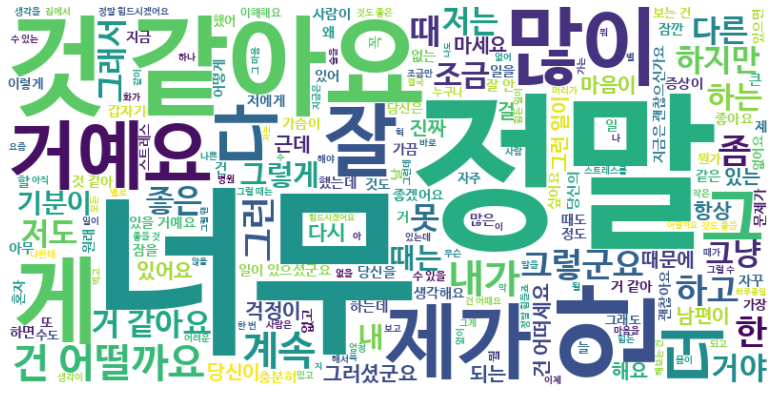

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from wordcloud import WordCloud

# 사용 가능한 폰트 리스트 출력
available_fonts = [font for font in fm.fontManager.ttflist if 'Nanum' in font.name or 'nanum' in font.name]

if available_fonts:
    chosen_font = available_fonts[0].fname  # 첫 번째 폰트의 파일명을 선택
    print("선택된 폰트:", chosen_font)

    # 워드 클라우드 생성 시 선택된 폰트를 지정
    wordcloud = WordCloud(font_path=chosen_font, width=800, height=400, background_color='white').generate(' '.join(all_words))
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
else:
    print("Nanum 폰트가 사용 가능한 폰트 리스트에 없습니다.")

In [ ]:
# 결측값을 제거하고 문자열 데이터만을 가지고 있는 행만 선택
combined_data = combined_data.dropna(subset=['A'])
combined_data.loc[:, 'Q_length'] = combined_data['Q'].apply(lambda x: len(x.split()))
combined_data.loc[:, 'A_length'] = combined_data['A'].apply(lambda x: len(x.split()))
print("\n질문 길이 통계:\n", combined_data['Q_length'].describe())
print("\n답변 길이 통계:\n", combined_data['A_length'].describe())


질문 길이 통계:
 count    12857.000000
mean         3.935677
std          2.179803
min          1.000000
25%          3.000000
50%          3.000000
75%          5.000000
max         22.000000
Name: Q_length, dtype: float64

답변 길이 통계:
 count    12857.000000
mean         4.021234
std          2.280317
min          1.000000
25%          2.000000
50%          4.000000
75%          5.000000
max         21.000000
Name: A_length, dtype: float64


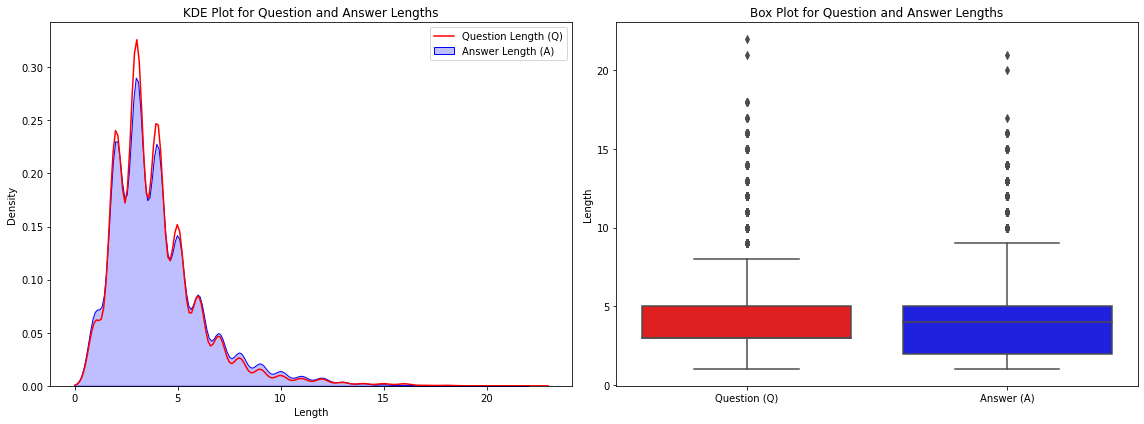

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터프레임에서 'Q'와 'A' 컬럼을 추출하여 각각의 길이를 구합니다.
question_lengths = [len(q.split()) for q in combined_data['Q']]
answer_lengths = [len(a.split()) for a in combined_data['A']]

# 캔버스 생성
plt.figure(figsize=(16, 6))

# KDE 그래프 (좌측) - Question(Q)와 Answer(A) 같이 그리기
plt.subplot(1, 2, 1)
sns.kdeplot(question_lengths, color='red', label='Question Length (Q)', fill=False)
sns.kdeplot(answer_lengths, color='blue', label='Answer Length (A)', fill=True)
plt.title('KDE Plot for Question and Answer Lengths')
plt.xlabel('Length')
plt.ylabel('Density')
plt.legend()

# Boxplot 그래프 (우측) - Question(Q)와 Answer(A) 같이 그리기
plt.subplot(1, 2, 2)
sns.boxplot(data=[question_lengths, answer_lengths], palette=['red', 'blue'])
plt.title('Box Plot for Question and Answer Lengths')
plt.ylabel('Length')
plt.xticks([0, 1], ['Question (Q)', 'Answer (A)'])

# 그래프 표시
plt.tight_layout()
plt.show()

### 전처리 및 데이터셋 구축


In [ ]:
questions = combined_data['Q'].tolist()  # 질문(Q) 컬럼을 리스트로 변환
answers = combined_data['A'].tolist()  # 답변(A) 컬럼을 리스트로 변환

In [ ]:
# 질문(Q) 컬럼을 리스트로 변환하고 구두점에 대해 띄어쓰기 적용
questions = [re.sub(r"([?.!,])", r" \1 ", question) for question in questions]

# 답변(A) 컬럼을 리스트로 변환하고 구두점에 대해 띄어쓰기 적용
answers = [re.sub(r"([?.!,])", r" \1 ", answer) for answer in answers]

In [ ]:
# 처리 결과 확인
list(zip(questions, answers))[:5]

[('12시 땡 ! ', '하루가 또 가네요 . '),
 ('1지망 학교 떨어졌어', '위로해 드립니다 . '),
 ('3박4일 놀러가고 싶다', '여행은 언제나 좋죠 . '),
 ('3박4일 정도 놀러가고 싶다', '여행은 언제나 좋죠 . '),
 ('PPL 심하네', '눈살이 찌푸려지죠 . ')]

In [ ]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [ ]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [7673]
종료 토큰 번호 : [7674]
단어 집합의 크기 : 7675


In [ ]:
# # 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
# MAX_LENGTH = 40

questions, answers = tokenize_and_pad(questions, answers)


print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))
print('필터링 후 질문 데이터의 크기(shape) :', questions.shape)
print('필터링 후 답변 데이터의 크기(shape) :', answers.shape)

단어장의 크기 : 7675
필터링 후의 질문 샘플 개수: 12857
필터링 후의 답변 샘플 개수: 12857
필터링 후 질문 데이터의 크기(shape) : (12857, 40)
필터링 후 답변 데이터의 크기(shape) : (12857, 40)


In [ ]:
BATCH_SIZE = 64  # 배치 크기 설정
BUFFER_SIZE = 20000  # 데이터를 섞을 버퍼 크기 설정 (데이터셋보다 크게 설정)

# 디코더의 입력과 출력 데이터셋 구성
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,  # 입력 데이터로 질문을 사용
        'dec_inputs': answers[:, :-1]  # 디코더의 입력 데이터로 이전 답변의 일부를 사용 (START_TOKEN 제외)
    },
    {
        'outputs': answers[:, 1:]  # 디코더의 출력 데이터로 실제 답변의 일부를 사용 (END_TOKEN 제외)
    },
))

dataset = dataset.cache()  # 데이터 캐싱
dataset = dataset.shuffle(BUFFER_SIZE)  # 버퍼 크기만큼 데이터셋을 섞음
dataset = dataset.batch(BATCH_SIZE)  # 배치 크기에 맞게 데이터셋을 배치화
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)  # 데이터 미리 로딩 설정

### 모델 구축


In [ ]:
# TensorFlow 세션 초기화
tf.keras.backend.clear_session()

# 하이퍼파라미터 설정
D_MODEL = 512 # 256에서 수정
NUM_LAYERS = 6 # 2에서 6으로 수정
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1
# UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기(모델 성능 & 복잡도 설정)

# 트랜스포머 모델 생성
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 7675, 512)
(1, 7675, 512)


### 모델 컴파일


In [ ]:
# Learning Rate 스케줄링 설정
learning_rate = CustomSchedule(D_MODEL)

# Adam 옵티마이저 설정
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 정확도 함수 정의
def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# 모델 컴파일
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("모델 컴파일 완료")

모델 컴파일 완료


### 모델 훈련


In [ ]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
201/201 [==============================] - 59s 207ms/step - loss: 1.4733 - accuracy: 0.0241
Epoch 2/50
201/201 [==============================] - 42s 211ms/step - loss: 1.1858 - accuracy: 0.0489
Epoch 3/50
201/201 [==============================] - 43s 213ms/step - loss: 1.0907 - accuracy: 0.0512
Epoch 4/50
201/201 [==============================] - 43s 215ms/step - loss: 1.0365 - accuracy: 0.0544
Epoch 5/50
201/201 [==============================] - 43s 216ms/step - loss: 0.9902 - accuracy: 0.0572
Epoch 6/50
201/201 [==============================] - 44s 217ms/step - loss: 0.9454 - accuracy: 0.0599
Epoch 7/50
201/201 [==============================] - 44s 218ms/step - loss: 0.8962 - accuracy: 0.0628
Epoch 8/50
201/201 [==============================] - 44s 218ms/step - loss: 0.8418 - accuracy: 0.0667
Epoch 9/50
201/201 [==============================] - 44s 219ms/step - loss: 0.7834 - accuracy: 0.0718
Epoch 10/50
201/201 [==============================] - 44s 219ms/step - l

### 모델 성능 평가


### 샘플데이터 문장 입력하여 답변 확인

- 데이터셋의 head 부분 5개 문장에 대한 답변을 확인합니다.


In [ ]:
sentence_generation('12시 땡!')

원본 데이터셋 Pair
입력 : 12시 땡!
출력 : 12시 땡!
--------------------


'마스크 쓰고 나가세요 . '

In [ ]:
sentence_generation('1집망 학교 떨어졌어')

원본 데이터셋 Pair
입력 : 1집망 학교 떨어졌어
출력 : 1집망 학교 떨어졌어
--------------------


'방 여러 개인 집에서 사세요 . '

In [ ]:
sentence_generation('3박4일 놀러가고 싶다.')

원본 데이터셋 Pair
입력 : 3박4일 놀러가고 싶다.
출력 : 3박4일 놀러가고 싶다.
--------------------


'숨 쉴만 했으면 좋겠네요 . '

In [ ]:
sentence_generation('3박4일 정도 놀러가고 싶다.')

원본 데이터셋 Pair
입력 : 3박4일 정도 놀러가고 싶다.
출력 : 3박4일 정도 놀러가고 싶다.
--------------------


'숨 쉴만 했으면 좋겠네요 . '

In [ ]:
sentence_generation('PPL 심하네')

원본 데이터셋 Pair
입력 : PPL 심하네
출력 : PPL 심하네
--------------------


'저 말씀이신가요 ? '

### 랜덤 샘플 추출하여 답변 확인


In [ ]:
import random

questions_samples = train_data['Q'].to_list()
answers_samples = train_data['A'].to_list()

# questions와 answers 리스트가 있다고 가정할 때,
random_pairs = random.sample(list(zip(questions_samples, answers_samples)), 10)
print(random_pairs)

[('고백하고 후회하면 어떡하지', '후회는 후회를 낳을뿐이에요. 용기 내세요.'), ('주고 받았던 편지도 버려야겠지?', '버릴 건 버려야지요.'), ('남자친구 부모님 만났는데 진짜 좋았어', '좋은 분끼리 만났나봐요.'), ('전남친 보고 싶어', '세상은 넓고 사람은 많아요.'), ('자꾸 신경쓰여', '관심이 가나봐요.'), ('에휴', '힘든 일이 있었나봐요.'), ('연금 믿어도 될까', '없는 것보다 나을 거예요.'), ('추석연휴가 그렇게 좋지만은 않다.', '이김에 푹 쉬는 건 어떨까요. 영화도 보고 맛있는 거 먹고.'), ('휴. 생일인데 기운빠지네', '생일 축하해요!'), ('이별 후 1년 그리고 선물', '이별하신게 맞나요.')]


In [ ]:
# random_pairs 리스트를 iteration하면서 sentence_generation 함수를 적용
for q, a in random_pairs:
    print('-'*20)
    print("입력한 문장: ", q)
    print('-'*20)
    print("생성된 답변: \n")
    print(sentence_generation(q))
    print()

--------------------
입력한 문장:  고백하고 후회하면 어떡하지
--------------------
생성된 답변: 

원본 데이터셋 Pair
입력 : 고백하고 후회하면 어떡하지
출력 : 고백하고 후회하면 어떡하지
--------------------
너무 신경 곤두세우지 마세요 . 

--------------------
입력한 문장:  주고 받았던 편지도 버려야겠지?
--------------------
생성된 답변: 

원본 데이터셋 Pair
입력 : 주고 받았던 편지도 버려야겠지?
출력 : 주고 받았던 편지도 버려야겠지?
--------------------
사랑은 따지는 게 아니고 다 주고도 더 주지 못해 미안해하는 거예요 . 

--------------------
입력한 문장:  남자친구 부모님 만났는데 진짜 좋았어
--------------------
생성된 답변: 

원본 데이터셋 Pair
입력 : 남자친구 부모님 만났는데 진짜 좋았어
출력 : 남자친구 부모님 만났는데 진짜 좋았어
--------------------
좋은 생각이에요 . 

--------------------
입력한 문장:  전남친 보고 싶어
--------------------
생성된 답변: 

원본 데이터셋 Pair
입력 : 전남친 보고 싶어
출력 : 전남친 보고 싶어
--------------------
세상은 넓고 사람은 많아요 . 

--------------------
입력한 문장:  자꾸 신경쓰여
--------------------
생성된 답변: 

원본 데이터셋 Pair
입력 : 자꾸 신경쓰여
출력 : 자꾸 신경쓰여
--------------------
저도 궁금하네요 . 

--------------------
입력한 문장:  에휴
--------------------
생성된 답변: 

원본 데이터셋 Pair
입력 : 에휴
출력 : 에휴
--------------------
많이 사랑했나봐요 . 

--------------------
입력한

### 학습하지 않은 문장에 대한 답변 확인


In [ ]:
sentence_generation('12시인데 배가 너무 고파')

원본 데이터셋 Pair
입력 : 12시인데 배가 너무 고파
출력 : 12시인데 배가 너무 고파
--------------------


'재미있게 놀다 오세요 . '

In [ ]:
sentence_generation('이 드라마는 PPL이 너무 심한거 같아')

원본 데이터셋 Pair
입력 : 이 드라마는 PPL이 너무 심한거 같아
출력 : 이 드라마는 PPL이 너무 심한거 같아
--------------------


'운동으로 만들어 보아요 . '

In [ ]:
sentence_generation('여자친구랑 헤어졌는데 너무 슬퍼')

원본 데이터셋 Pair
입력 : 여자친구랑 헤어졌는데 너무 슬퍼
출력 : 여자친구랑 헤어졌는데 너무 슬퍼
--------------------


'상황이 원하지 않는 방향으로 흘렀나봐요 . '

In [ ]:
sentence_generation('읽을만한 책을 추천해줄래?')

원본 데이터셋 Pair
입력 : 읽을만한 책을 추천해줄래?
출력 : 읽을만한 책을 추천해줄래?
--------------------


'누구나 한번쯤 시도해 볼 만하죠 . '

In [ ]:
sentence_generation('나 오늘 헤어짐')

원본 데이터셋 Pair
입력 : 나 오늘 헤어짐
출력 : 나 오늘 헤어짐
--------------------


'좋아하나봐요 . '

In [ ]:
sentence_generation('15박 16일정도 쉴수있었으면 좋겠다.')

원본 데이터셋 Pair
입력 : 15박 16일정도 쉴수있었으면 좋겠다.
출력 : 15박 16일정도 쉴수있었으면 좋겠다.
--------------------


'그게 진짜 사랑이네요 . '

In [ ]:
sentence_generation('15박16일 놀러가고 싶다.')

원본 데이터셋 Pair
입력 : 15박16일 놀러가고 싶다.
출력 : 15박16일 놀러가고 싶다.
--------------------


'달달할 시기네요 . '

### 모델 성능 평가


### 성능 개선 방안 수립

- 데이터셋 규모가 그리 크지 않다보니 성능 향상에 한계가 있어 보입니다.
- Transfer Learning을 활용해서 성능 향상을 시도해보겠습니다.
- 특히, 한국어 처리에 좀 더 특화된 `kogpt2-transformers` 를 사용해서 시도해보겠습니다.

- [Reference Document: 위키북스 koGPT2 챗봇 만들기](https://wikidocs.net/157001)


## koGPT2를 적용한 Transfer Learning 모델 생성

- 데이터셋은 기존데이터에 신규데이터를 추가한 데이터셋을 그대로 사용합니다.


In [6]:
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningModule
from torch.utils.data import DataLoader, Dataset
from transformers.optimization import AdamW, get_cosine_schedule_with_warmup
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel

### 데이터 전처리

- 허깅페이스의 PreTrainedTokenizer 인 GPT2Tokenizer 를 사용
  - 입력 문자열을 token id로 변환(encoindg)하거나 token id를 다시 문자열로 변환(decoding)
  - 기존 구조에 추가적 token 들 추가
  - Special token들을 (mask, BOS, EOS 등) 관리


- 스페셜 토큰 정의


In [7]:
Q_TKN = "<usr>"
A_TKN = "<sys>"
BOS = '</s>'
EOS = '</s>'
MASK = '<unused0>'
SENT = '<unused1>'
PAD = '<pad>'

- 허깅페이스의 koGPT2 모델 & 토크나이저 불러오기


In [32]:
koGPT2_TOKENIZER = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
            bos_token=BOS, eos_token=EOS, unk_token='<unk>',
            pad_token=PAD, mask_token=MASK)
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


### 데이터셋 정의

- 데이터는 기존 데이터에 추가데이를 병합한 데이터셋 사용


In [9]:
# 챗봇 데이터를 처리하는 클래스를 만든다.
class ChatbotDataset(Dataset):
    def __init__(self, chats, max_len=40):  # 데이터셋의 전처리를 해주는 부분
        self._data = chats
        self.max_len = max_len
        self.q_token = Q_TKN
        self.a_token = A_TKN
        self.sent_token = SENT
        self.eos = EOS
        self.mask = MASK
        self.tokenizer = koGPT2_TOKENIZER

    def __len__(self):  # chatbotdata 의 길이를 리턴한다.
        return len(self._data)

    def __getitem__(self, idx):  # 로드한 챗봇 데이터를 차례차례 DataLoader로 넘겨주는 메서드
        turn = self._data.iloc[idx]
        q = turn["Q"]  # 질문을 가져온다.
        q = re.sub(r"([?.!,])", r" ", q)  # 구둣점들을 제거한다.

        a = turn["A"]  # 답변을 가져온다.
        a = re.sub(r"([?.!,])", r" ", a)  # 구둣점들을 제거한다.

        q_toked = self.tokenizer.tokenize(self.q_token + q + self.sent_token)
        q_len = len(q_toked)

        a_toked = self.tokenizer.tokenize(self.a_token + a + self.eos)
        a_len = len(a_toked)

        #질문의 길이가 최대길이보다 크면
        if q_len > self.max_len:
            a_len = self.max_len - q_len        #답변의 길이를 최대길이 - 질문길이
            if a_len <= 0:       #질문의 길이가 너무 길어 질문만으로 최대 길이를 초과 한다면
                q_toked = q_toked[-(int(self.max_len / 2)) :]   #질문길이를 최대길이의 반으로
                q_len = len(q_toked)
                a_len = self.max_len - q_len              #답변의 길이를 최대길이 - 질문길이
            a_toked = a_toked[:a_len]
            a_len = len(a_toked)

        #질문의 길이 + 답변의 길이가 최대길이보다 크면
        if q_len + a_len > self.max_len:
            a_len = self.max_len - q_len        #답변의 길이를 최대길이 - 질문길이
            if a_len <= 0:       #질문의 길이가 너무 길어 질문만으로 최대 길이를 초과 한다면
                q_toked = q_toked[-(int(self.max_len / 2)) :]   #질문길이를 최대길이의 반으로
                q_len = len(q_toked)
                a_len = self.max_len - q_len              #답변의 길이를 최대길이 - 질문길이
            a_toked = a_toked[:a_len]
            a_len = len(a_toked)

        # 답변 labels = [mask, mask, ...., mask, ..., <bos>,..답변.. <eos>, <pad>....]
        labels = [self.mask,] * q_len + a_toked[1:]

        # mask = 질문길이 0 + 답변길이 1 + 나머지 0
        mask = [0] * q_len + [1] * a_len + [0] * (self.max_len - q_len - a_len)
        # 답변 labels을 index 로 만든다.
        labels_ids = self.tokenizer.convert_tokens_to_ids(labels)
        # 최대길이만큼 PADDING
        while len(labels_ids) < self.max_len:
            labels_ids += [self.tokenizer.pad_token_id]

        # 질문 + 답변을 index 로 만든다.
        token_ids = self.tokenizer.convert_tokens_to_ids(q_toked + a_toked)
        # 최대길이만큼 PADDING
        while len(token_ids) < self.max_len:
            token_ids += [self.tokenizer.pad_token_id]

        #질문+답변, 마스크, 답변
        return (token_ids, np.array(mask), labels_ids)

In [22]:
def collate_batch(batch):
    data = [item[0] for item in batch]
    mask = [item[1] for item in batch]
    label = [item[2] for item in batch]
    return torch.LongTensor(data), torch.LongTensor(mask), torch.LongTensor(label)

In [33]:
import urllib.request

urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv",
    filename="ChatBotData.csv",
)
Chatbot_Data = pd.read_csv("ChatBotData.csv")
# Test 용으로 300개 데이터만 처리한다.
Chatbot_Data = Chatbot_Data[:300]
Chatbot_Data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [41]:
from torch.utils.data import DataLoader

# 챗봇 데이터셋 인스턴스 생성
chatbot_dataset = ChatbotDataset(Chatbot_Data)

# DataLoader 인스턴스 생성
train_dataloader = DataLoader(chatbot_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_set = ChatbotDataset(Chatbot_Data, max_len=40)
#윈도우 환경에서 num_workers 는 무조건 0으로 지정, 리눅스에서는 2
train_dataloader = DataLoader(train_set, batch_size=32, num_workers=0, shuffle=True, collate_fn=collate_batch,)

### 모델학습


In [43]:
model.to(device)
model.train()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

In [44]:
learning_rate = 3e-5
criterion = torch.nn.CrossEntropyLoss(reduction="none")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch = 10
Sneg = -1e18


In [46]:

print ("start")
for epoch in range(epoch):
    for batch_idx, samples in enumerate(train_dataloader):
        optimizer.zero_grad()
        token_ids, mask, label = samples
        out = model(token_ids)
        out = out.logits      #Returns a new tensor with the logit of the elements of input
        mask_3d = mask.unsqueeze(dim=2).repeat_interleave(repeats=out.shape[2], dim=2)
        mask_out = torch.where(mask_3d == 1, out, Sneg * torch.ones_like(out))
        loss = criterion(mask_out.transpose(2, 1), label)
        # 평균 loss 만들기 avg_loss[0] / avg_loss[1] <- loss 정규화
        avg_loss = loss.sum() / mask.sum()
        avg_loss.backward()
        # 학습 끝
        optimizer.step()
print ("end")


start
end


### 모델 성능 테스트


In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

with torch.no_grad():
    while 1:
        q = input("user > ").strip()
        if q == "quit":
            break
        a = ""
        while 1:
            input_ids = torch.LongTensor(koGPT2_TOKENIZER.encode(Q_TKN + q + SENT + sent + A_TKN + a)).unsqueeze(dim=0)
            pred = model(input_ids)
            pred = pred.logits
            gen = koGPT2_TOKENIZER.convert_ids_to_tokens(torch.argmax(pred, dim=-1).squeeze().numpy().tolist())[-1]
            if gen == EOS:
                break
            a += gen.replace("▁", " ")
        print("Chatbot > {}".format(a.strip()))

user > 12시 땡


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

# 회고

## KEEP

- 모델의 기초적인 작동과정을 이해하고 코드로 1 cycle을 구현해봤다.
- 구현해본 모델에 성능 개선을 위해 데이터 추가, 하이퍼 파라미터 조정 등의 작업을 설계하고 실험해봤다.

## PROBLEM

- Transfer Learning을 함께 시도하려했는데 마지막 테스트 부분에서의 문제를 해결하지 못했다.
- 애초에 코드를 이해했다기 보다는 레퍼런스 코드를 거의 그대로 인용한것이라 이해없이 따라하려 해서 생긴 문제

## TRY

- Transfer Learning 적용한 코드 구현해보기
